In [1]:
import os
import laspy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as colors
import seaborn as sns
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin
import skgstat as skg
from skgstat import OrdinaryKriging as SKGOrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error


# ========= PROCESAMIENTO =========
def procesar_lidar(carpeta, LAT_mean):
    """Procesa todos los archivos LAS/LAZ en una carpeta"""
    x_total, y_total, z_total = [], [], []
    archivos_procesados = 0
    
    print(f"🔍 Buscando archivos LiDAR en: {carpeta}")
    
    for archivo in tqdm(os.listdir(carpeta)):
        if archivo.lower().endswith((".las", ".laz")):
            ruta = os.path.join(carpeta, archivo)
            try:
                with laspy.open(ruta) as las:
                    las = las.read()
                    x_total.append(np.array(las.x))
                    y_total.append(np.array(las.y))
                    z_total.append(np.array(las.z))
                archivos_procesados += 1
            except Exception as e:
                print(f"\n⚠️ Error en {archivo}: {str(e)}")
    
    if not x_total:
        raise ValueError("No se encontraron archivos LiDAR válidos")
    
    z_total = [z - LAT_mean for z in z_total]  # Ajuste de altura
    print(f"\n✅ Procesados {archivos_procesados} archivos")
    return np.concatenate(x_total), np.concatenate(y_total), np.concatenate(z_total)

# ========= VISUALIZACIÓN 2D =========
def visualizar_mapa_2d(x, y, z, figurax =20, figuray=8,  orientacion = 'vertical'):
    """Crea un mapa 2D de los puntos con colores según altura"""
    plt.figure(figsize=(figurax, figuray))
    
    # Normalizamos las alturas para el colormap
    norm = colors.Normalize(vmin=np.min(z), vmax=np.max(z))
    
    # Scatter plot con colores según altura
    sc = plt.scatter(x, y, c=z, cmap='jet', s=0.1, norm=norm)
    
    # Configuración del gráfico
    plt.title("Mapa 2D de Puntos LiDAR (Color por Altura)", fontweight='bold')
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    
    # Añadir barra de color
    cbar = plt.colorbar(sc, orientation = orientacion, shrink=0.5)
    cbar.set_label('Altura (m)')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
       
    
import matplotlib.pyplot as plt

def histograma(z):
    """
    Muestra un histograma y un boxplot de los valores de altura (Z)
    en una sola figura, organizados verticalmente.
    
    Parámetros:
    - z: array-like, lista o array de valores de altura.
    """
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, 
        ncols=1, 
        figsize=(12, 8), 
        gridspec_kw={'height_ratios': [4, 1]},
        sharex=True
    )

    # Histograma
    ax1.hist(z, bins=50, color='#00007F')
    ax1.set_title("Distribución de Alturas (Z)", fontweight='bold')
    ax1.set_ylabel("Frecuencia")
    ax1.grid(alpha=0.3)

    # Boxplot
    ax2.boxplot(z, vert=False, patch_artist=True,
                boxprops=dict(facecolor='#00007F', color='grey'),
                medianprops=dict(color='#7F0000'))
    ax2.set_xlabel("Altura (m)")
    ax2.grid(alpha=0.3)

    plt.tight_layout()

# ========= ANÁLISIS ADICIONAL =========
def analisis_adicional(z):
    """Cálculo de métricas básicas"""
    print("\n📊 Métricas de altura:")
    print(f" - Máxima: {np.max(z):.2f} m")
    print(f" - Mínima: {np.min(z):.2f} m")
    print(f" - Media: {np.mean(z):.2f} m")
    print(f" - Desviación estándar: {np.std(z):.2f} m")
    
# Versión mejorada del heatmap de altura con contornos
def generar_heatmap(x, y, bins=100, figurax =20, figuray=8, orientacion = 'horizontal'):
    """Heatmap sin contornos, usando colormap 'jet'."""
    fig, ax = plt.subplots(figsize=(figurax, figuray))
    
    # Calculamos el histograma 2D
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    
    # Dibujamos el heatmap
    im = ax.imshow(
        heatmap.T,
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap='Oranges',
        aspect='auto'
    )
    
    # Configuración de la barra de color y ejes
    cbar = fig.colorbar(im, ax=ax, label='Frecuencia', shrink=0.8, orientation = orientacion )
    ax.set_title('Heatmap de Puntos', fontweight='bold')
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.grid(False)  # Quitamos la cuadrícula
    
    plt.tight_layout()
  
import numpy as np
import matplotlib.pyplot as plt
import skgstat as skg

def calcular_semivariograma(x, y, z, num_bins=30, modelo='spherical'):
    """
    Calcula el semivariograma de una muestra de los datos y ajusta un modelo.

    Args:
        x, y, z (np.ndarray): Coordenadas X, Y y valores Z.
        num_bins (int): Número de bins para el semivariograma.

    Returns:
        tuple: Objeto Variogram y parámetros del modelo.
    """
    num_datos = len(x)
    if num_datos != len(y) or num_datos != len(z):
        raise ValueError("Los arrays x, y, z deben tener la misma longitud.")

    if num_datos > 10000:
        indices_muestra = np.random.choice(num_datos, 10000, replace=False)
        x, y, z = x[indices_muestra], y[indices_muestra], z[indices_muestra]

    # Coordenadas combinadas
    coords = np.column_stack((x, y))

    # Crear y ajustar el semivariograma
    variograma = skg.Variogram(coords, z)
    variograma.model = modelo
    variograma.n_lags = num_bins
    variograma.maxlag = 500

    # Extraer parámetros ajustados
    params = variograma.parameters
    parametros = {
        'range': params[0],
        'sill': params[1]
    }
    if len(params) == 3:
        parametros['nugget'] = params[2]

    return variograma, parametros

import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
from skgstat import OrdinaryKriging as SKGOrdinaryKriging

def kriging_interpolacion_skg(x, y, z, grid_res=100, modelo='exponential'):
    """
    Realiza interpolación por Kriging ordinario en 2D usando scikit-gstat.

    Args:
        x (np.ndarray): Coordenadas X.
        y (np.ndarray): Coordenadas Y.
        z (np.ndarray): Valores Z (por ejemplo, alturas).
        grid_res (int): Resolución del grid para la interpolación.
        modelo (str): Modelo de semivariograma ('linear', 'power', 'gaussian', 'spherical', 'exponential').

    Returns:
        tuple: (grid_x, grid_y, z_kriging) -> coordenadas y resultado de interpolación.
    """
    # Submuestreo si hay demasiados puntos
    if len(x) > 10000:
        idx = np.random.choice(len(x), 10000, replace=False)
        x, y, z = x[idx], y[idx], z[idx]

    coords = np.column_stack((x, y))

    # Crear y ajustar semivariograma
    V = Variogram(coords, z, model=modelo, n_lags=30, maxlag='median')
    OK = SKGOrdinaryKriging(V)

    # Crear grilla
    gridx = np.linspace(min(x), max(x), grid_res)
    gridy = np.linspace(min(y), max(y), grid_res)
    xx, yy = np.meshgrid(gridx, gridy)
    grid_coords = np.column_stack([xx.ravel(), yy.ravel()])

    # Ejecutar Kriging
    z_pred = OK.transform(grid_coords)
    z_krig = z_pred.reshape((grid_res, grid_res))

     

    return gridx, gridy, z_krig



def kriging_errores_validacion_cruzada(x, y, z, grid_res=100, modelo='exponential', num_folds=5):
    """
    Realiza interpolación de Kriging con validación cruzada y calcula los errores.

    Args:
        x (np.ndarray): Coordenadas X.
        y (np.ndarray): Coordenadas Y.
        z (np.ndarray): Valores Z.
        grid_res (int): Resolución de la grilla para la interpolación.
        modelo (str): Modelo de semivariograma.
        num_folds (int): Número de folds para la validación cruzada.

    Returns:
        tuple: (grid_x, grid_y, z_kriging, error_map, mse, r2, variograma)
                grid_x, grid_y: Coordenadas de la grilla.
                z_kriging: Valores Z interpolados.
                error_map: Mapa de los errores de predicción.
                mse: Error cuadrático medio de la validación cruzada.
                r2: Coeficiente de determinación de la validación cruzada.
                variograma: Objeto variograma ajustado.
    """
    if len(x) > 10000:
        idx = np.random.choice(len(x), 10000, replace=False)
        x_sub, y_sub, z_sub = x[idx], y[idx], z[idx]
    else:
        x_sub, y_sub, z_sub = x, y, z

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Para reproducibilidad
    errores = []
    z_real_values = []
    z_pred_values = []
    all_test_points = []  # Para almacenar todos los puntos de prueba
    all_test_errors = []    # Para almacenar todos los errores de prueba
    final_variograma = None

    for train_index, test_index in kf.split(x_sub): # Usar los datos submuestreados para la validación cruzada
        x_train, x_test = x_sub[train_index], x_sub[test_index]
        y_train, y_test = y_sub[train_index], y_sub[test_index]
        z_train, z_test = z_sub[train_index], z_sub[test_index]

        # Calcular el semivariograma en el conjunto de entrenamiento
        variograma, _ = calcular_semivariograma(x_train, y_train, z_train, modelo=modelo)
        final_variograma = variograma # Guardar el último variograma

        # Inicializar Kriging con el semivariograma del conjunto de entrenamiento
        OK = SKGOrdinaryKriging(variograma)

        # Interpolar los puntos de prueba
        z_pred_test = OK.transform(np.column_stack((x_test, y_test)))
        errores.append(z_pred_test - z_test)
        z_real_values.extend(z_test)
        z_pred_values.extend(z_pred_test)

        all_test_points.extend(np.column_stack((x_test, y_test)))
        all_test_errors.extend(z_pred_test - z_test)

    # Calcular métricas de error
    rmse = root_mean_squared_error(z_real_values, z_pred_values)
    mse = mean_squared_error(z_real_values, z_pred_values)
    r2 = r2_score(z_real_values, z_pred_values)

    # Interpolar en la grilla completa para el mapa final
    gridx, gridy, z_kriging = kriging_interpolacion_skg(x, y, z, grid_res=grid_res, modelo=modelo)

    # Crear el mapa de errores interpolando los errores de validación cruzada
    error_map = griddata(np.array(all_test_points), np.array(all_test_errors), (gridx[None, :], gridy[:, None]), method='linear')

    return gridx, gridy, z_kriging, error_map, rmse, mse, r2, final_variograma





🔍 Buscando archivos LiDAR en: BahiaSolano


100%|██████████| 34/34 [00:00<00:00, 199.17it/s]


✅ Procesados 17 archivos


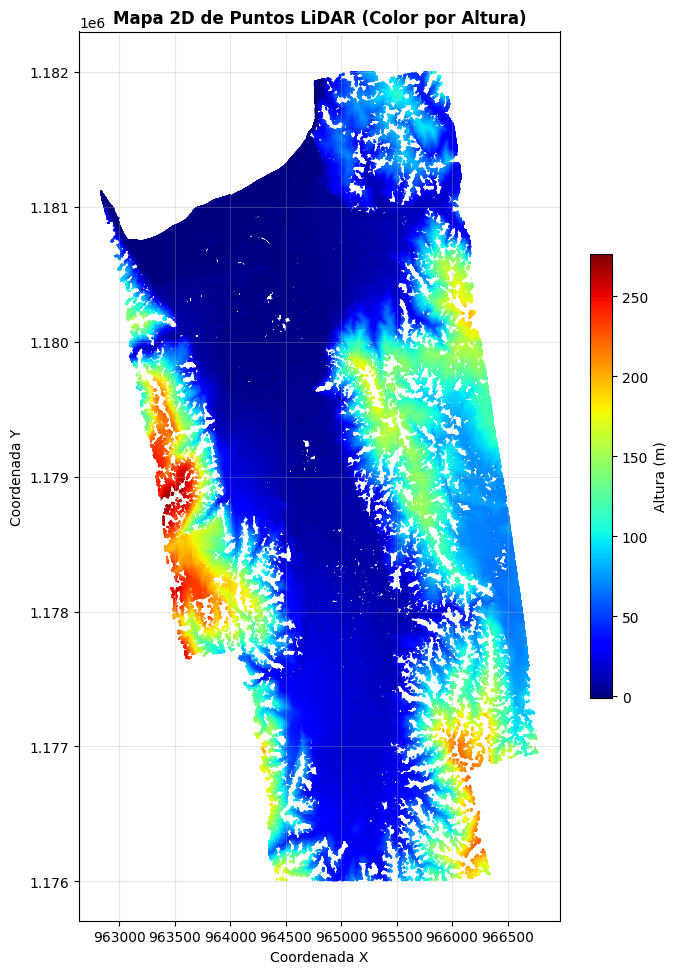

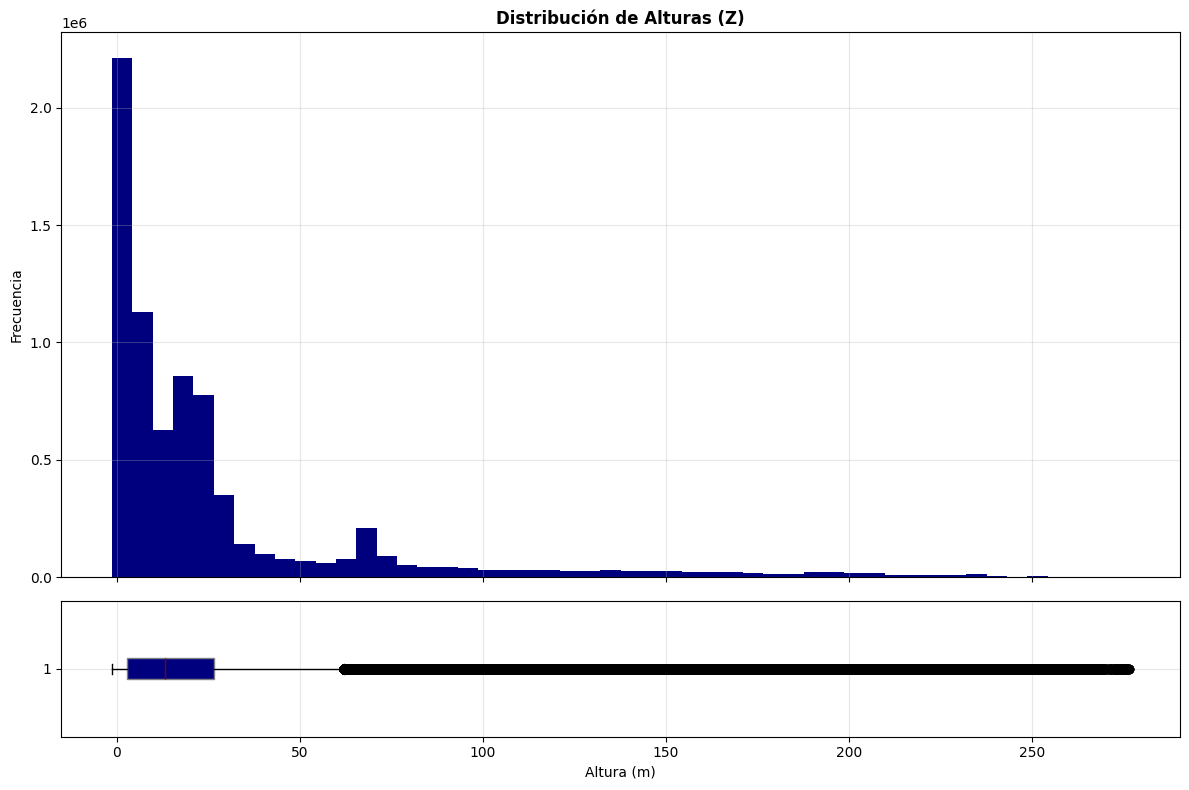


📊 Métricas de altura:
 - Máxima: 276.59 m
 - Mínima: -1.28 m
 - Media: 27.39 m
 - Desviación estándar: 42.25 m


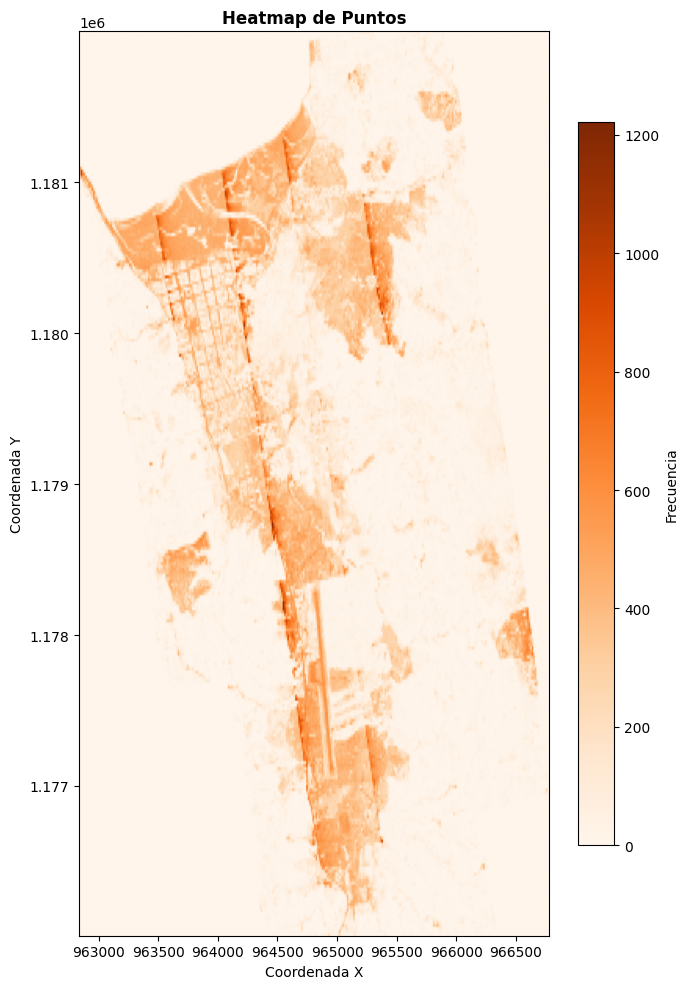

In [3]:
# ========= CONFIGURACIÓN =========
carpeta = "BahiaSolano"  # <-- Cambiar por tu ruta
magna_oeste = 'EPSG:3115'
LAT_mean = 17.88


# ========= EJECUCIÓN PRINCIPAL =========
if __name__ == "__main__":
    try:
        # 1. Procesar archivos
        x, y, z = procesar_lidar(carpeta, LAT_mean)
        
        # 2. Visualización (solo mapa 2D ahora)
        visualizar_mapa_2d(x, y, z, figurax =7, figuray=10, orientacion ='vertical')
        
        plt.savefig("Mapa_puntos_BahiaSolano.png", dpi=300)
        plt.show()
        
        histograma(z)
                     
        plt.savefig("histograma_BahiaSolano.png", dpi=300)
        plt.show()
        
        # 4. Análisis
        
        analisis_adicional(z)
        
        generar_heatmap(x, y, bins=300, figurax =7, figuray=10, orientacion='vertical')
        
        plt.savefig("heatmap_BahiaSolano.png", dpi=300)
        plt.show()
        
               
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")

/home/chrisbermudezr/Modelos_Terreno/env/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_56686/2027819401.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes1[i].legend()


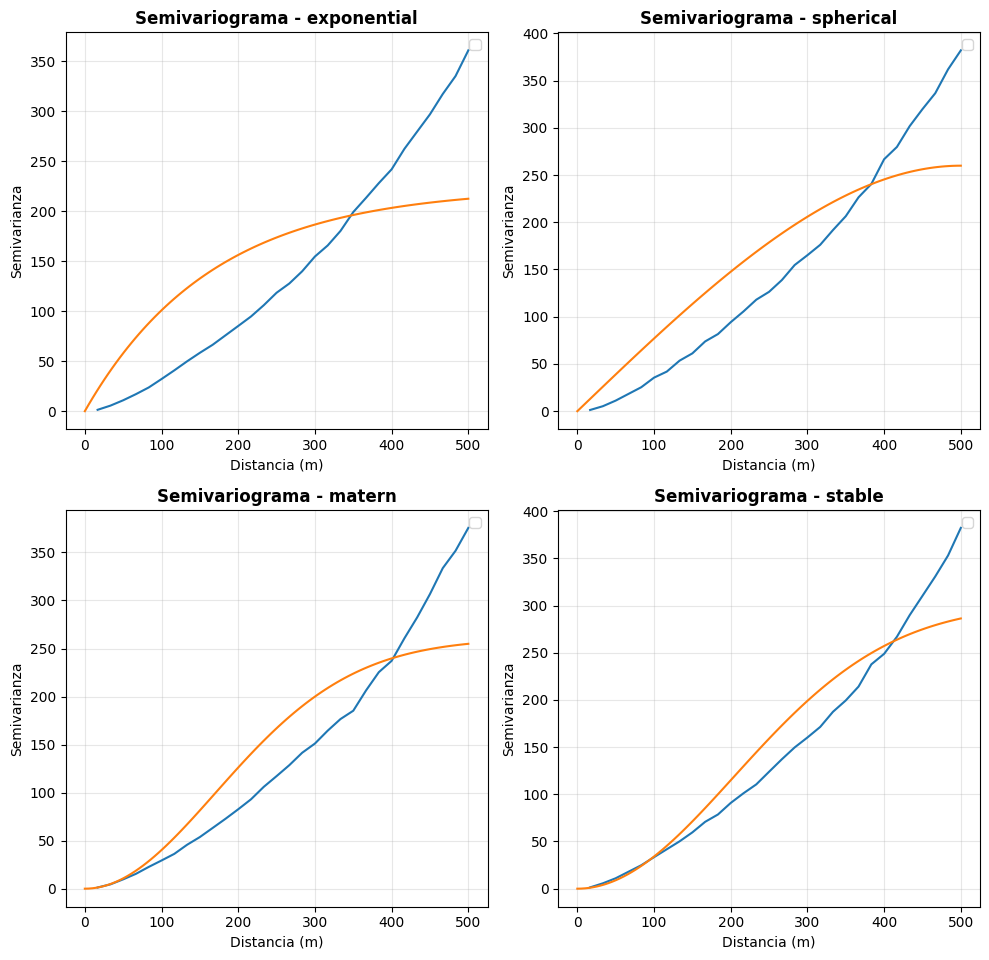

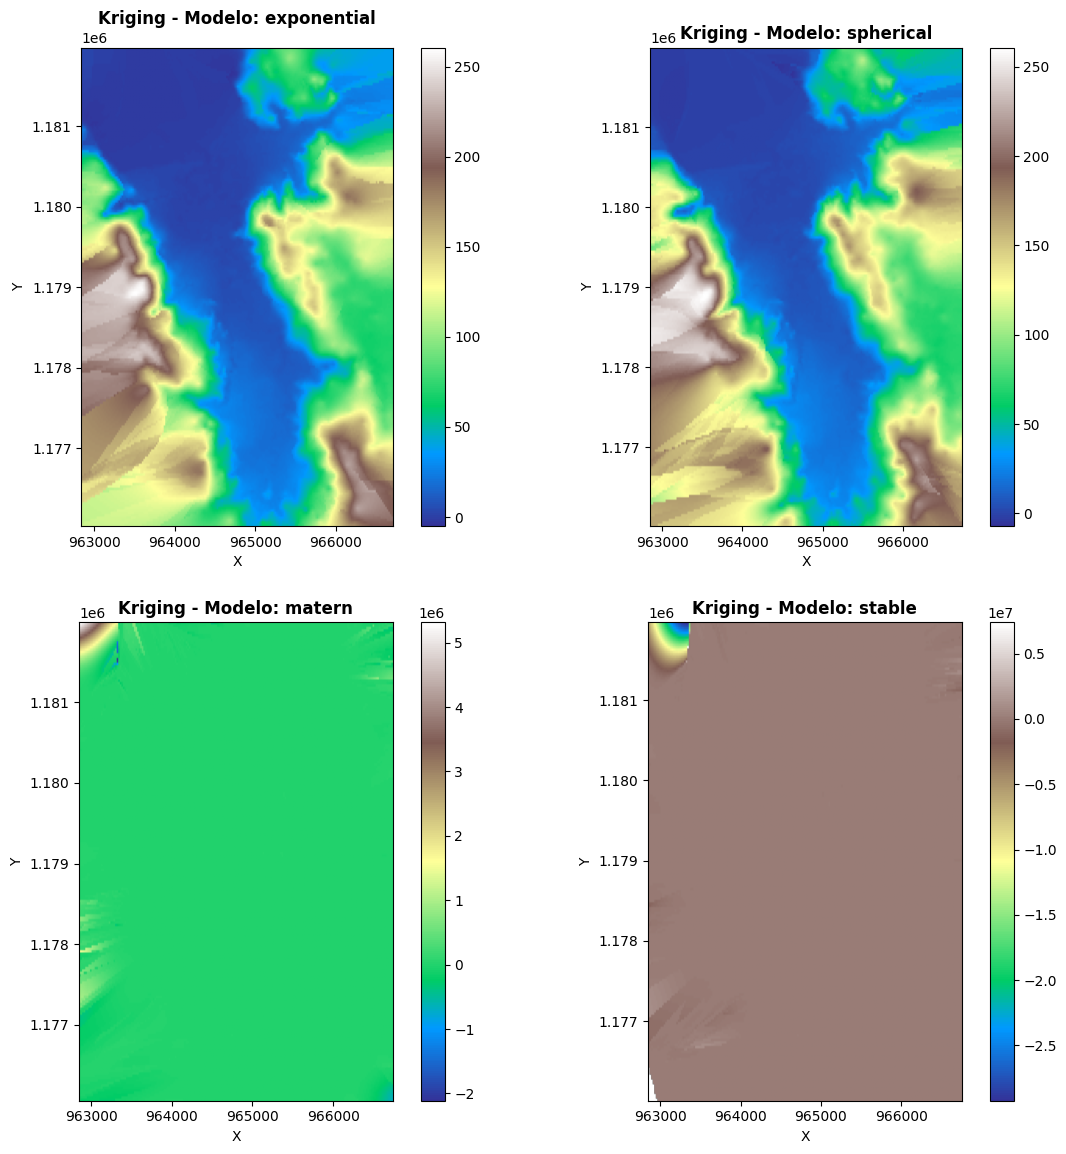

: 

In [ ]:
import matplotlib.pyplot as plt

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados_semivariograma = []
resultados_kriging = []

# --- Calcular semivariogramas ---
for modelo in modelos:
    variograma, parametros = calcular_semivariograma(x, y, z, num_bins=30, modelo=modelo)
    resultados_semivariograma.append((modelo, variograma, parametros))

# --- Ejecutar Kriging ---
for modelo in modelos:
    gridx, gridy, z_krig = kriging_interpolacion_skg(x, y, z, grid_res=200, modelo=modelo)
    resultados_kriging.append((modelo, gridx, gridy, z_krig))

# --- Gráfica de semivariogramas ---
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes1 = axes1.ravel()

for i, (modelo, variograma, parametros) in enumerate(resultados_semivariograma):
    fig_temp = variograma.plot()
    ax_temp = fig_temp.axes[0]

    for line in ax_temp.get_lines():
        axes1[i].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())

    axes1[i].set_title(f"Semivariograma - {modelo}", fontweight='bold')
    axes1[i].set_xlabel("Distancia (m)")
    axes1[i].set_ylabel("Semivarianza")
    axes1[i].grid(True, alpha=0.3)
    axes1[i].legend()
    plt.close(fig_temp)  # Cerrar figura temporal para evitar ventanas extras

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout(rect=[0, 0.03, 1, 1])
fig1.savefig("Semivariogramas_Experimentales_BahiaSolano.png", dpi=300)
plt.show()

# --- Gráfica de mapas Kriging ---
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes2 = axes2.ravel()

for i, (modelo, gridx, gridy, z_krig) in enumerate(resultados_kriging):
    im = axes2[i].imshow(
        z_krig,
        origin='lower',
        extent=[gridx[0], gridx[-1], gridy[0], gridy[-1]],
        cmap='terrain'
    )
    axes2[i].set_title(f'Kriging - Modelo: {modelo}', fontweight='bold')
    axes2[i].set_xlabel("X")
    axes2[i].set_ylabel("Y")
    fig2.colorbar(im, ax=axes2[i], orientation='vertical', fraction=0.046)

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout(rect=[0, 0.03, 1, 1])
fig2.savefig("kriging_BahiaSolano.png", dpi=300)
plt.show()



--- Resultados para el modelo: exponential ---
RMSE: 3.87 | MSE: 15.00 | R²: 0.99

--- Resultados para el modelo: spherical ---
RMSE: 3.47 | MSE: 12.07 | R²: 0.99

--- Resultados para el modelo: matern ---
RMSE: 49.89 | MSE: 2489.16 | R²: -0.35

--- Resultados para el modelo: stable ---
RMSE: 77.87 | MSE: 6063.98 | R²: -2.36


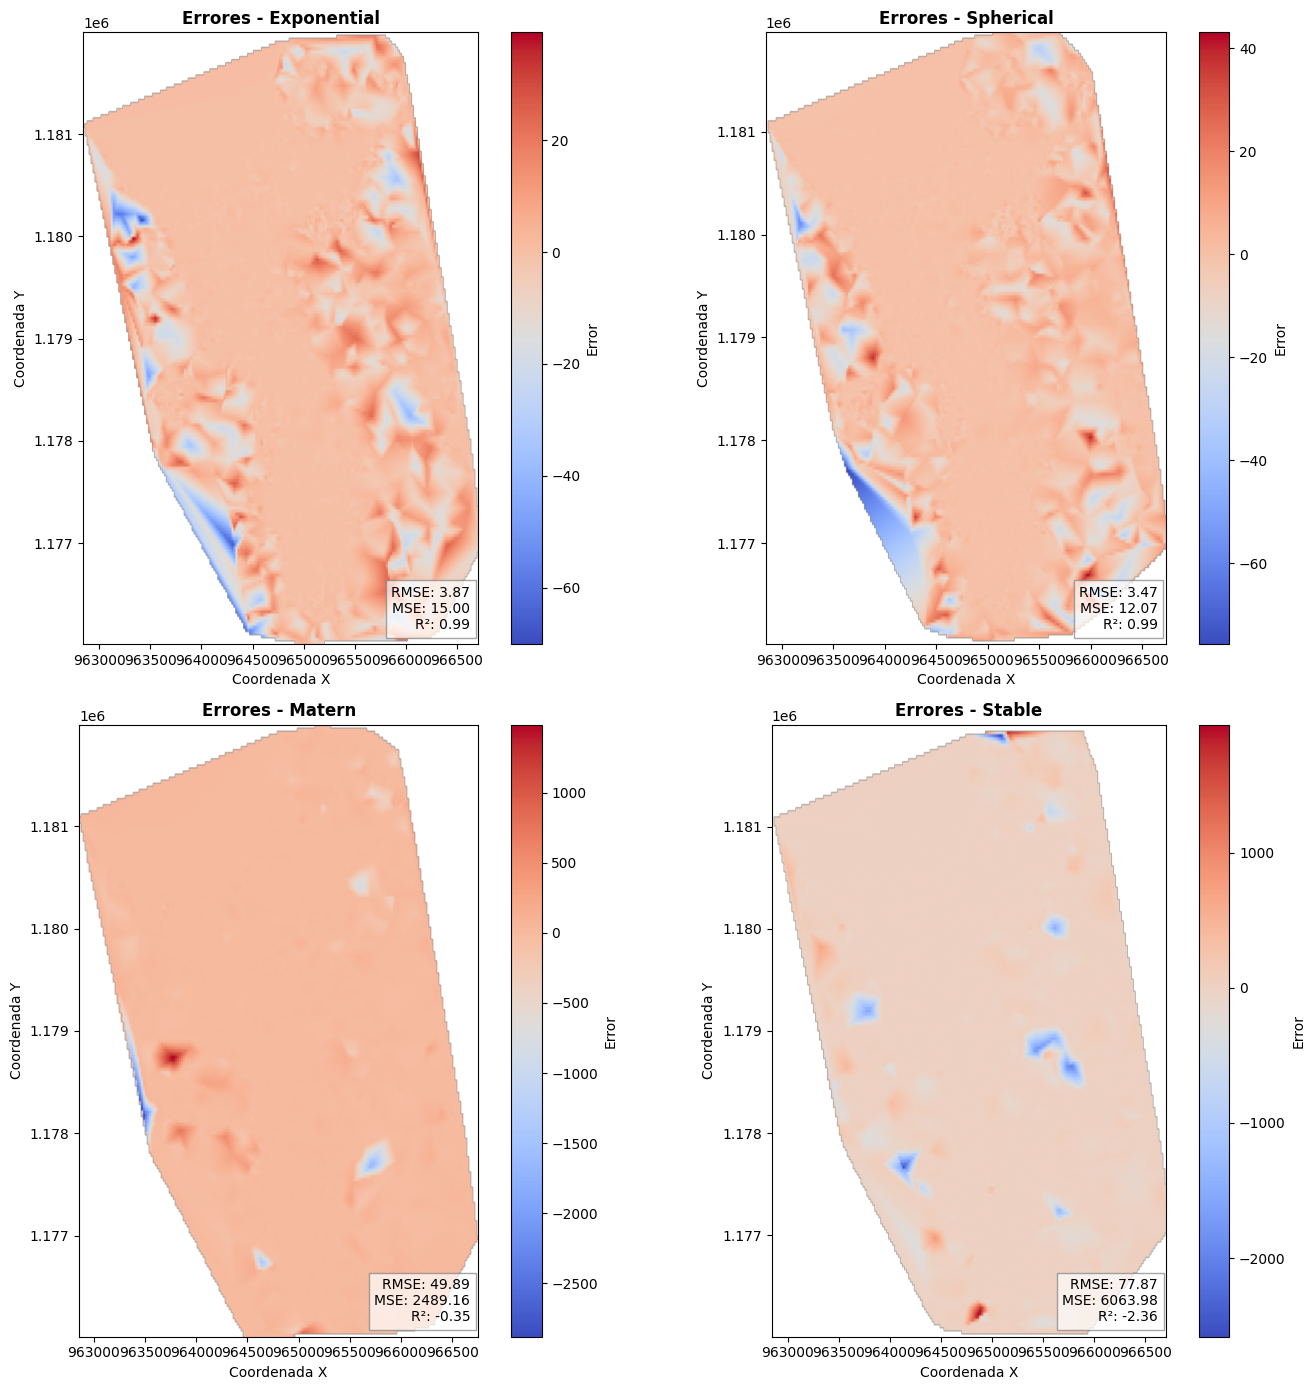

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados = []

# Ejecutar Kriging y validación cruzada para cada modelo
for modelo in modelos:
    print(f"\n--- Resultados para el modelo: {modelo} ---")
    gridx, gridy, z_kriging, error_map, rmse, mse, r2, final_variograma = kriging_errores_validacion_cruzada(
        x, y, z, grid_res=200, modelo=modelo, num_folds=5
    )
    rmse = np.sqrt(mse)
    
    print(f"RMSE: {rmse:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")
    
    resultados.append({
        'modelo': modelo,
        'gridx': gridx,
        'gridy': gridy,
        'error_map': error_map,
        'rmse': rmse,
        'mse': mse,
        'r2': r2
    })

# Crear figura 2x2 con los mapas de errores
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.ravel()

for i, res in enumerate(resultados):
    im = axs[i].imshow(
        res['error_map'],
        extent=(res['gridx'].min(), res['gridx'].max(), res['gridy'].min(), res['gridy'].max()),
        origin='lower',
        cmap='coolwarm'
    )
    axs[i].set_title(f"Errores - {res['modelo'].capitalize()}", fontweight='bold')
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    fig.colorbar(im, ax=axs[i], label="Error en metros", orientation='vertical', fraction=0.046)

    # Agregar texto con métricas en la esquina inferior derecha del subplot
    texto_metricas = f"RMSE: {res['rmse']:.2f}\nMSE: {res['mse']:.2f}\nR²: {res['r2']:.2f}"
    axs[i].text(0.98, 0.02, texto_metricas, transform=axs[i].transAxes,
                fontsize=10, color='black', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))

plt.tight_layout()
plt.savefig("errores_kriging_modelos.png", dpi=300)
plt.show()


 - Rango: 500.00 m
 - Sill: 290.86
 - Nugget: 0.00


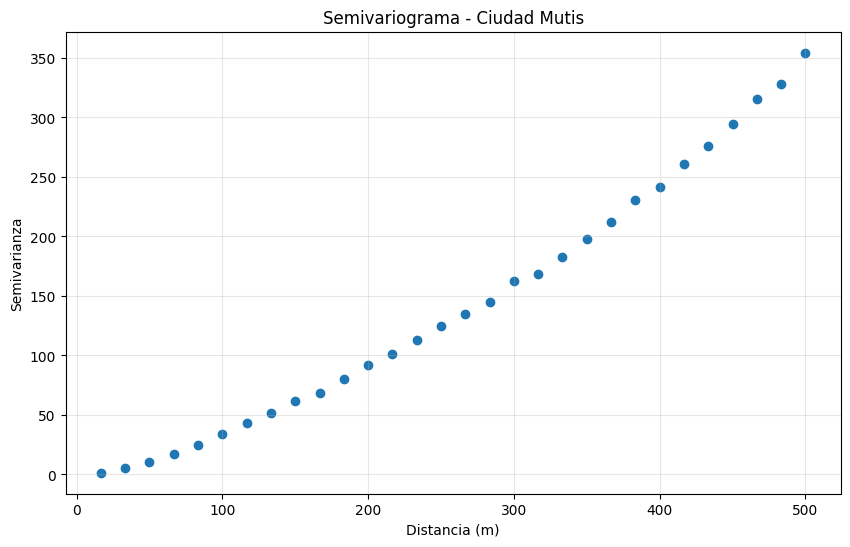

In [10]:
data = variograma.data(n=100, force=False)
x1 = variograma.bins
y1 = variograma.experimental
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x1, y1, label='Semivariograma')
ax.set_title(f"Semivariograma - Ciudad Mutis")
ax.set_xlabel("Distancia (m)")
ax.set_ylabel("Semivarianza")
ax.grid(True, alpha=0.3)
plt.savefig("Semivariograma_BahiaSolano.png", dpi=300)


parametros = variograma.parameters


print(f" - Rango: {parametros[0]:.2f} m")
print(f" - Sill: {parametros[1]:.2f}")
print(f" - Nugget: {parametros[3]:.2f}")

🔍 Buscando archivos LiDAR en: Buenaventura


100%|██████████| 72/72 [00:00<00:00, 859.77it/s]


✅ Procesados 17 archivos


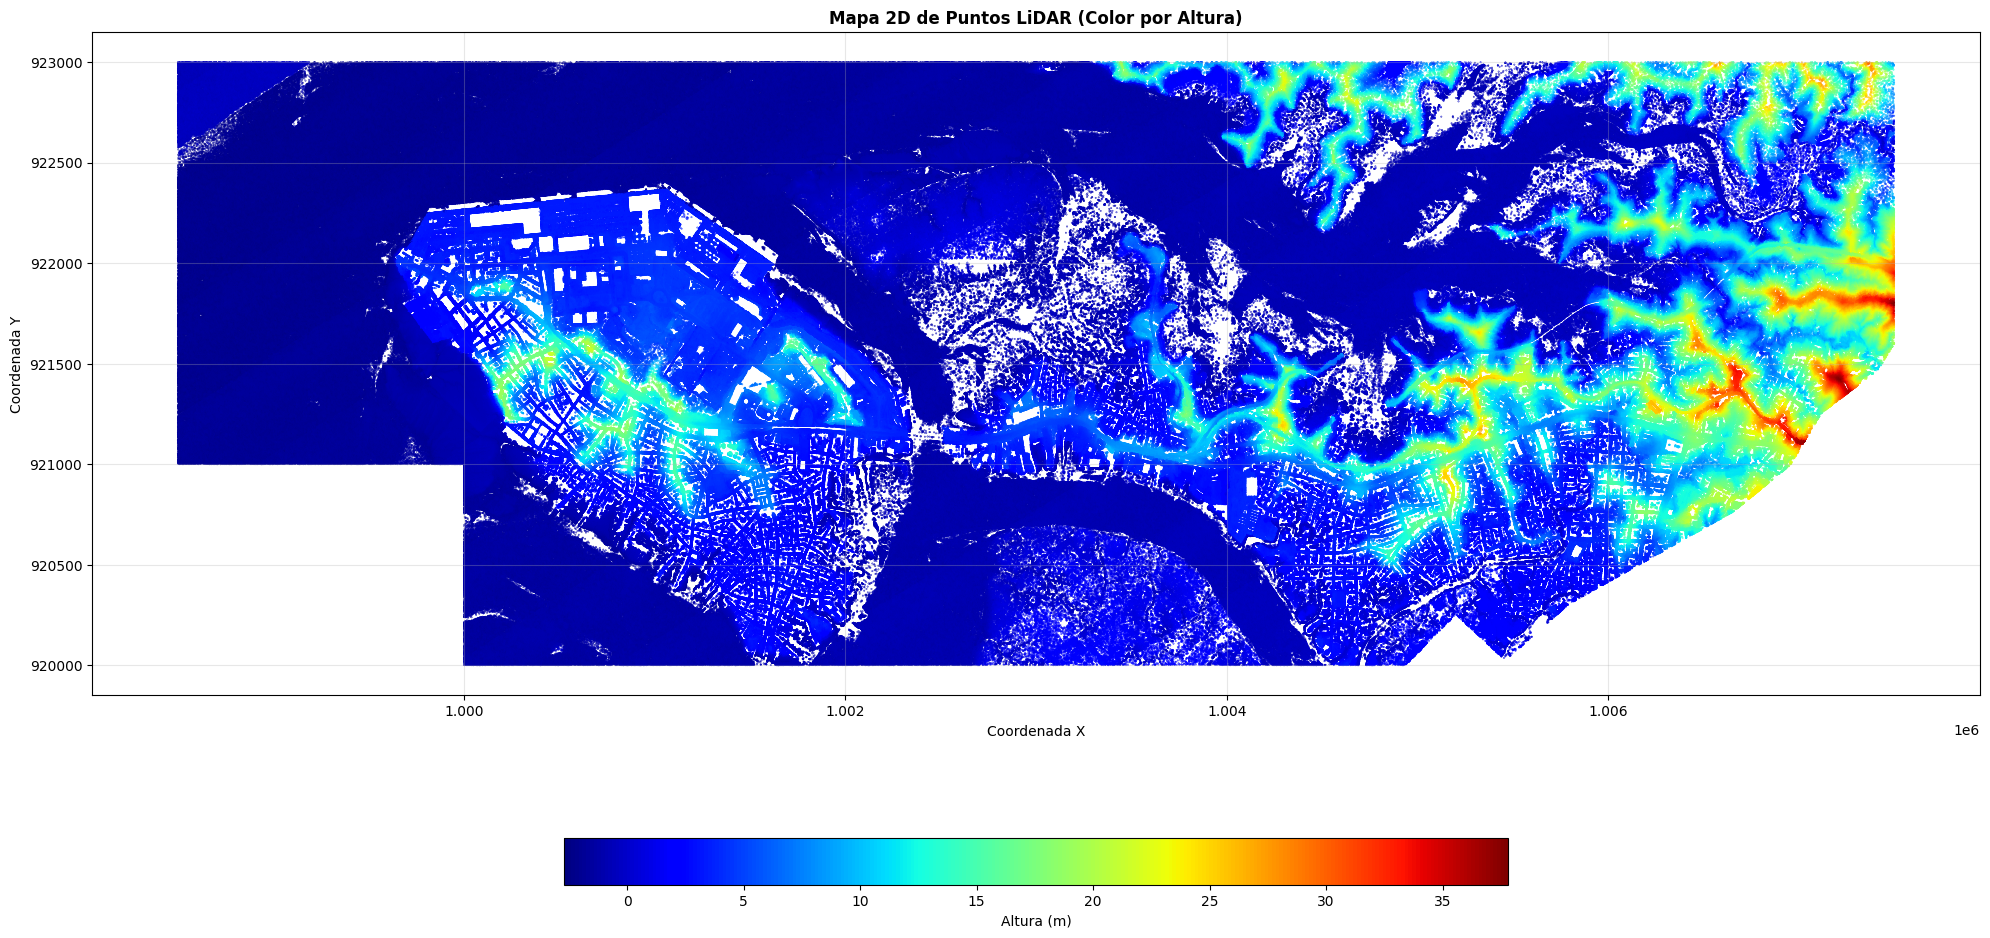

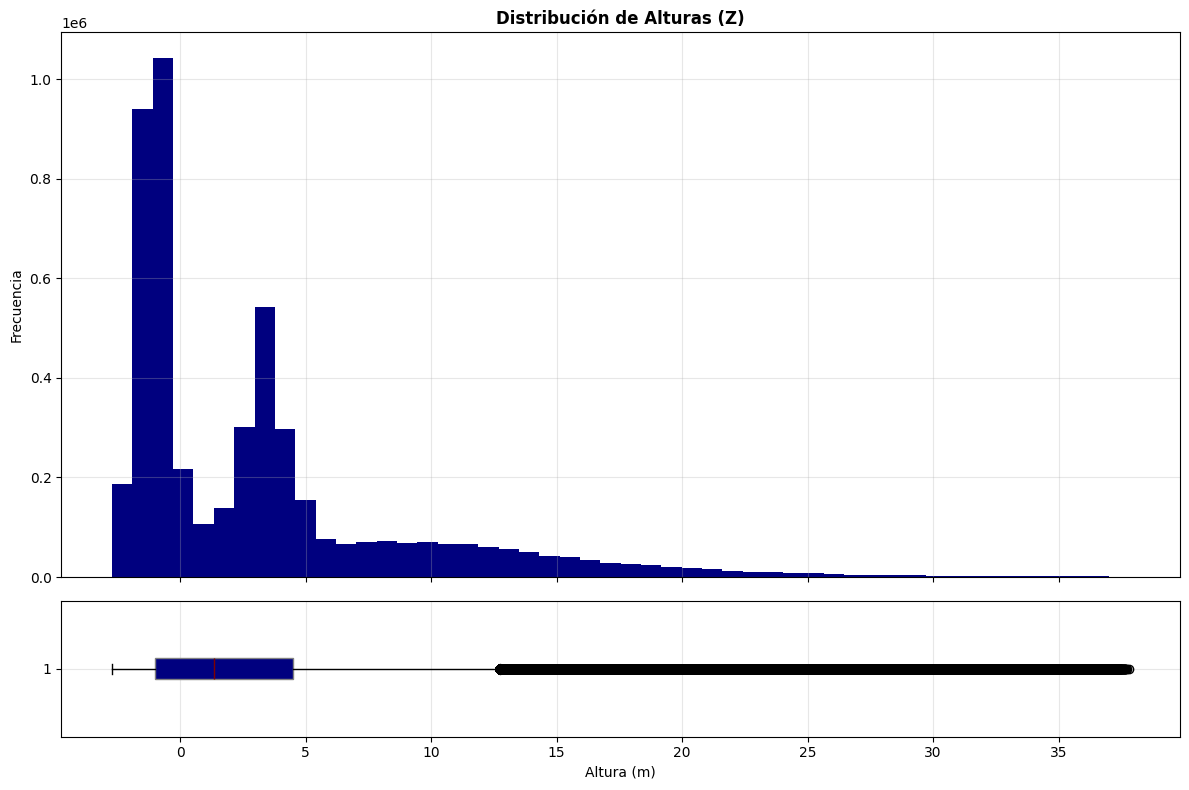


📊 Métricas de altura:
 - Máxima: 37.81 m
 - Mínima: -2.71 m
 - Media: 3.21 m
 - Desviación estándar: 5.99 m


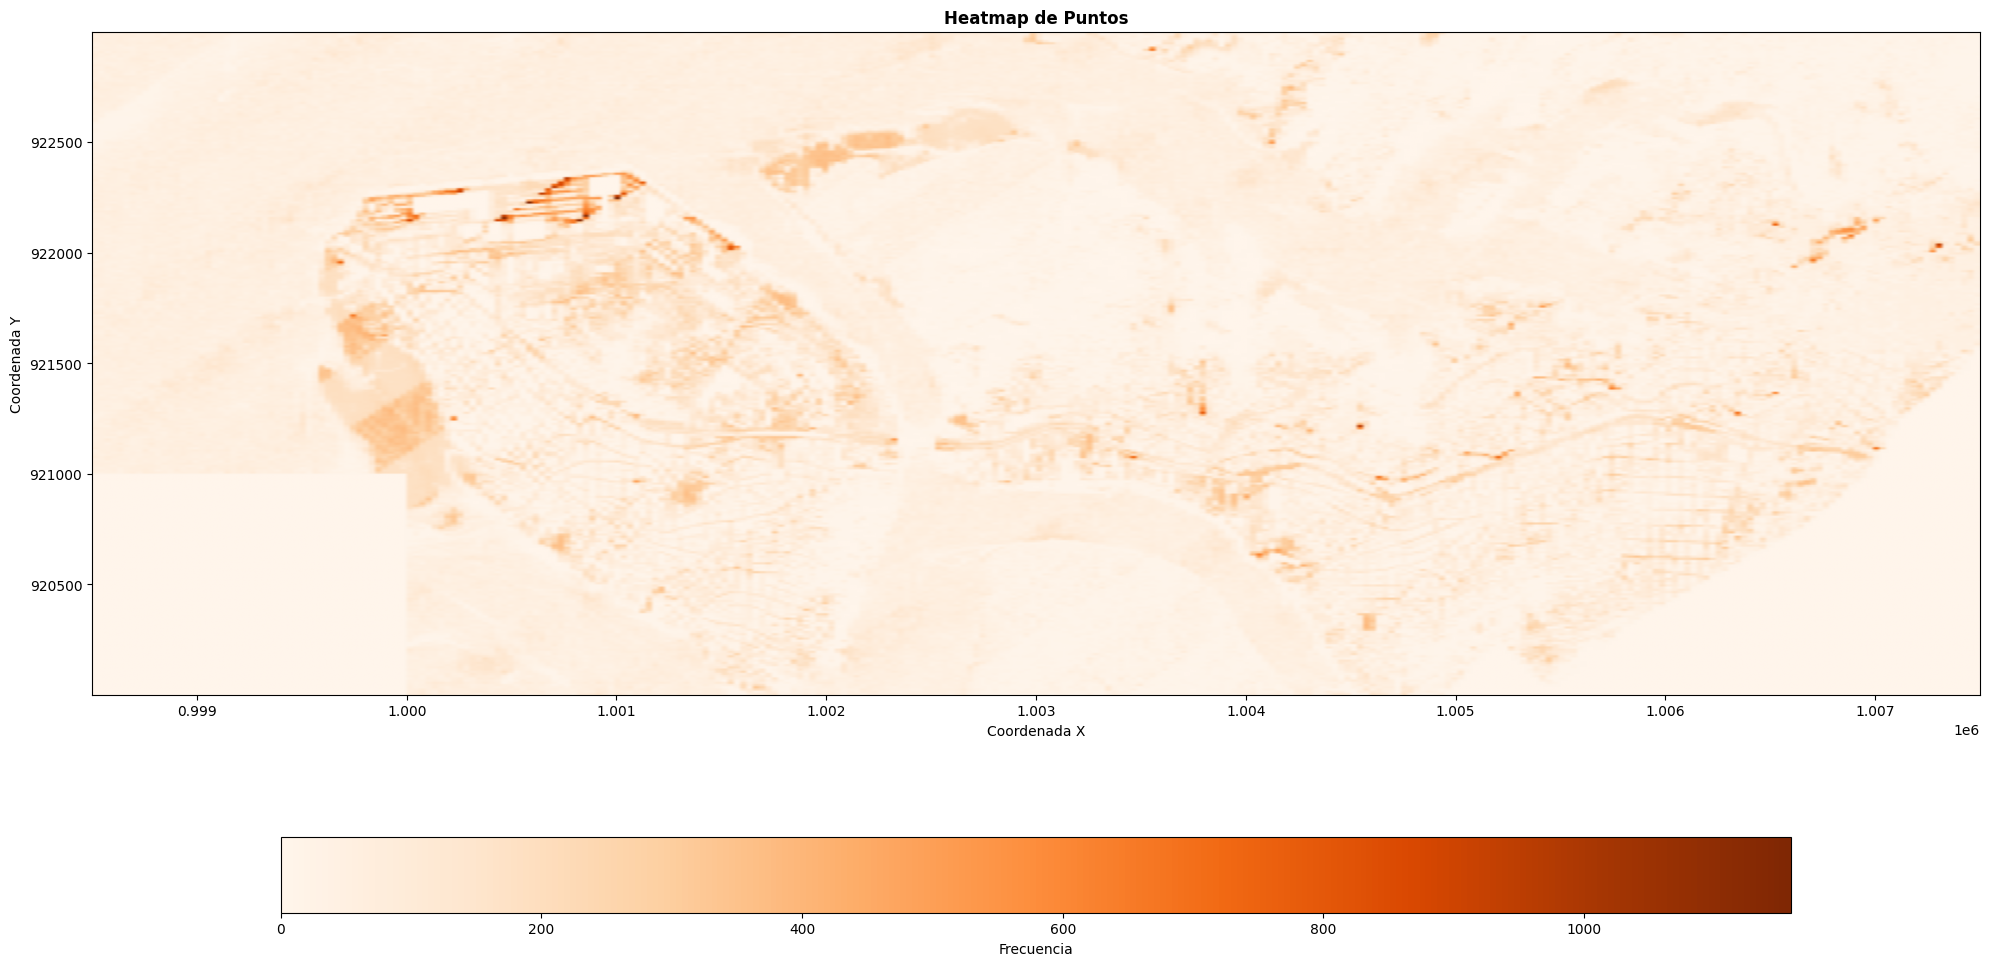

In [4]:

# ========= CONFIGURACIÓN =========
carpeta = "Buenaventura"  # <-- Cambiar por tu ruta
magna_oeste = 'EPSG:3115'

LAT_mean = 17.4793


# ========= EJECUCIÓN PRINCIPAL =========
if __name__ == "__main__":
    try:
        # 1. Procesar archivos
        x, y, z = procesar_lidar(carpeta, LAT_mean)
        
        # 2. Visualización (solo mapa 2D ahora)
        visualizar_mapa_2d(x, y, z, figurax =20, figuray=10, orientacion ='horizontal')
        
        plt.savefig("Mapa_puntos_buenaventura.png", dpi=300)
        plt.show()
        
        histograma(z)
                     
        plt.savefig("histograma_buenaventura.png", dpi=300)
        plt.show()
        
        # 4. Análisis
        
        analisis_adicional(z)
        
        generar_heatmap(x, y, bins=300, figurax =20, figuray=10, orientacion='horizontal')
        
        plt.savefig("heatmap_buenaventura.png", dpi=300)
        plt.show()
        
               
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")

/home/chrisbermudezr/Modelos_Terreno/env/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_66595/845471126.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes1[i].legend()


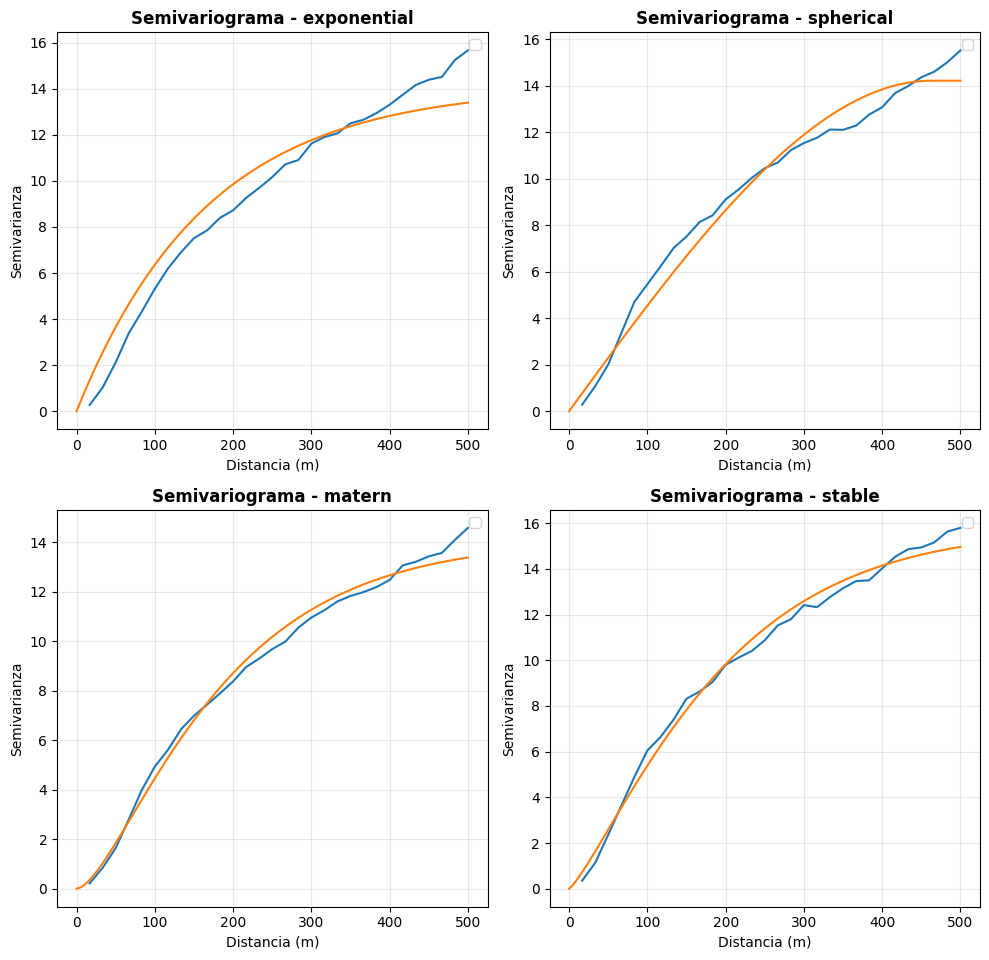

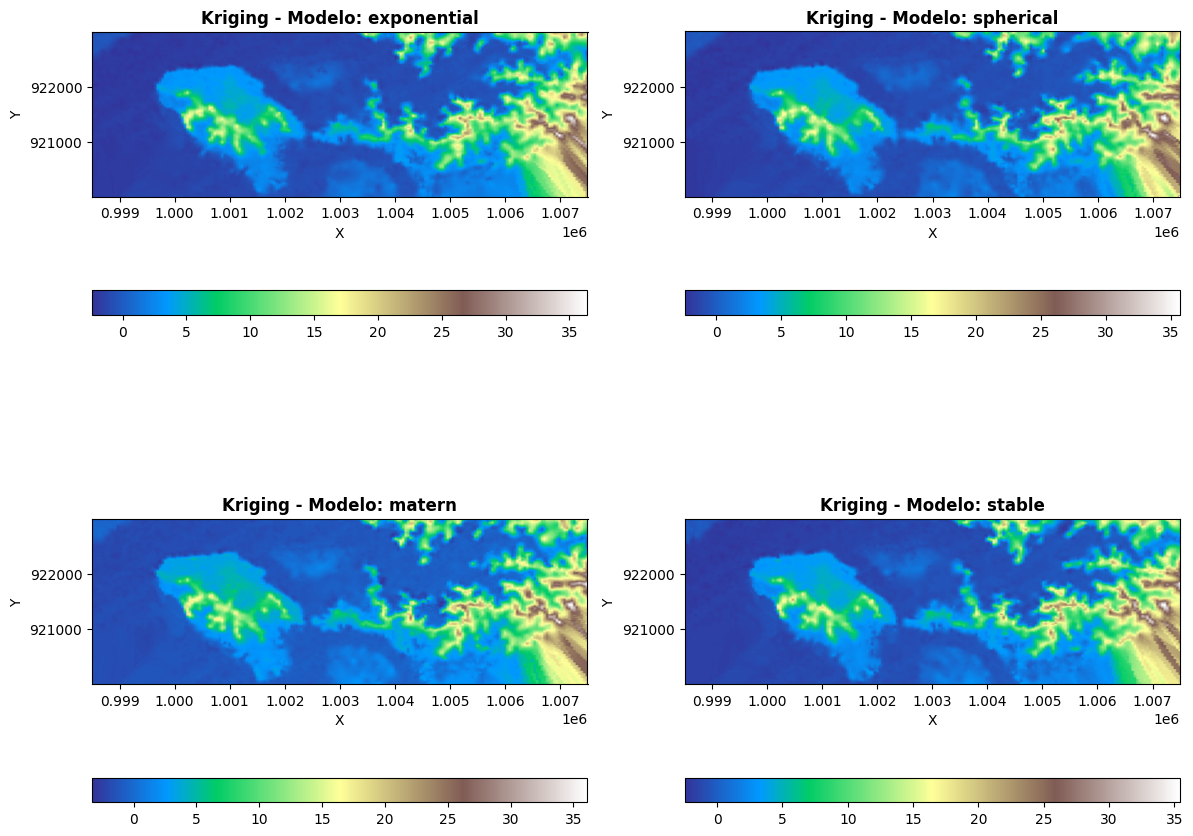

In [ ]:
import matplotlib.pyplot as plt

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados_semivariograma = []
resultados_kriging = []

# --- Calcular semivariogramas ---
for modelo in modelos:
    variograma, parametros = calcular_semivariograma(x, y, z, num_bins=30, modelo=modelo)
    resultados_semivariograma.append((modelo, variograma, parametros))

# --- Ejecutar Kriging ---
for modelo in modelos:
    gridx, gridy, z_krig = kriging_interpolacion_skg(x, y, z, grid_res=200, modelo=modelo)
    resultados_kriging.append((modelo, gridx, gridy, z_krig))

# --- Gráfica de semivariogramas ---
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes1 = axes1.ravel()

for i, (modelo, variograma, parametros) in enumerate(resultados_semivariograma):
    fig_temp = variograma.plot()
    ax_temp = fig_temp.axes[0]

    for line in ax_temp.get_lines():
        axes1[i].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())

    axes1[i].set_title(f"Semivariograma - {modelo}", fontweight='bold')
    axes1[i].set_xlabel("Distancia (m)")
    axes1[i].set_ylabel("Semivarianza")
    axes1[i].grid(True, alpha=0.3)
    axes1[i].legend()
    plt.close(fig_temp)  # Cerrar figura temporal para evitar ventanas extras

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout(rect=[0, 0.03, 1, 1])
fig1.savefig("Semivariogramas_Experimentales_Buenaventura.png", dpi=300)
plt.show()

# --- Gráfica de mapas Kriging ---
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes2 = axes2.ravel()

for i, (modelo, gridx, gridy, z_krig) in enumerate(resultados_kriging):
    im = axes2[i].imshow(
        z_krig,
        origin='lower',
        extent=[gridx[0], gridx[-1], gridy[0], gridy[-1]],
        cmap='terrain'
    )
    axes2[i].set_title(f'Kriging - Modelo: {modelo}', fontweight='bold')
    axes2[i].set_xlabel("X")
    axes2[i].set_ylabel("Y")
    fig2.colorbar(im, ax=axes2[i], orientation='horizontal', fraction=0.046)

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout(rect=[0, 0.03, 1, 1])
fig2.savefig("kriging_Buenaventura.png", dpi=300)
plt.show()





--- Resultados para el modelo: exponential ---
RMSE: 1.24 | MSE: 1.54 | R²: 0.95

--- Resultados para el modelo: spherical ---
RMSE: 1.25 | MSE: 1.57 | R²: 0.96

--- Resultados para el modelo: matern ---
RMSE: 1.17 | MSE: 1.37 | R²: 0.96

--- Resultados para el modelo: stable ---
RMSE: 1.19 | MSE: 1.41 | R²: 0.96


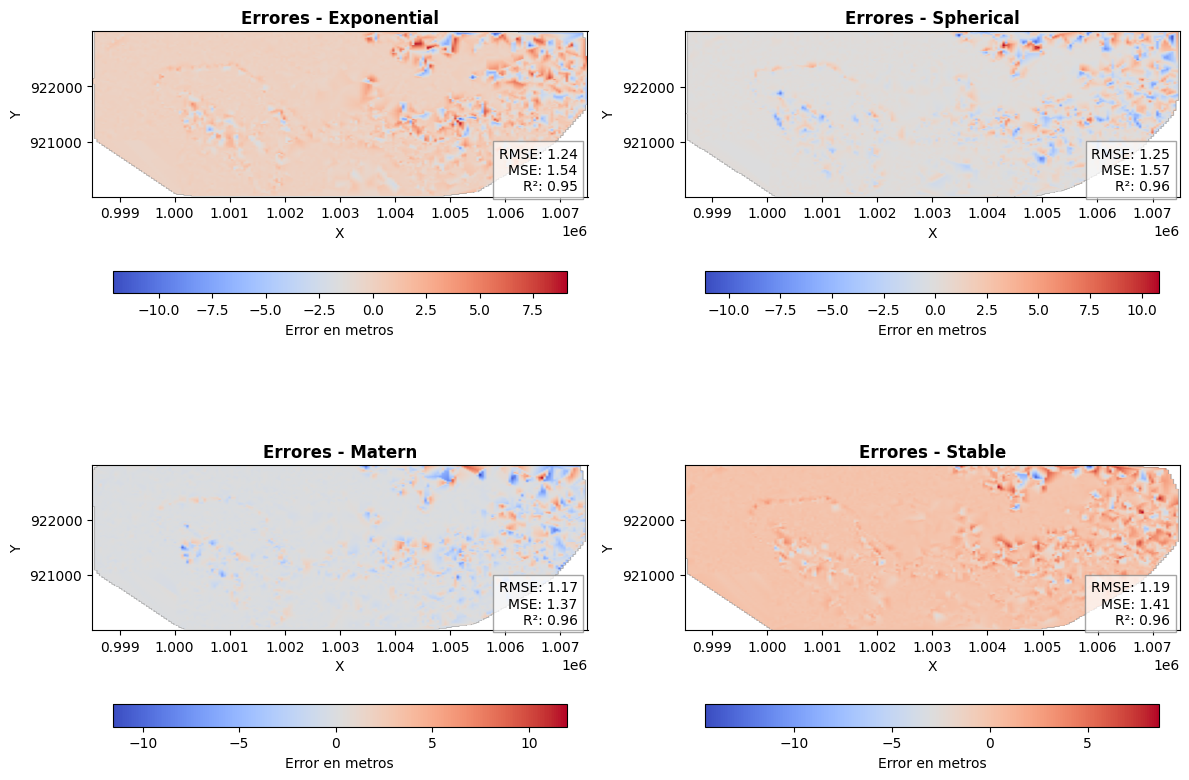

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados = []

# Ejecutar Kriging y validación cruzada para cada modelo
for modelo in modelos:
    print(f"\n--- Resultados para el modelo: {modelo} ---")
    gridx, gridy, z_kriging, error_map, rmse, mse, r2, final_variograma = kriging_errores_validacion_cruzada(
        x, y, z, grid_res=200, modelo=modelo, num_folds=5
    )
    rmse = np.sqrt(mse)
    
    print(f"RMSE: {rmse:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")
    
    resultados.append({
        'modelo': modelo,
        'gridx': gridx,
        'gridy': gridy,
        'error_map': error_map,
        'rmse': rmse,
        'mse': mse,
        'r2': r2
    })

# Crear figura 2x2 con los mapas de errores
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.ravel()

for i, res in enumerate(resultados):
    im = axs[i].imshow(
        res['error_map'],
        extent=(res['gridx'].min(), res['gridx'].max(), res['gridy'].min(), res['gridy'].max()),
        origin='lower',
        cmap='coolwarm'
    )
    axs[i].set_title(f"Errores - {res['modelo'].capitalize()}", fontweight='bold')
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    fig.colorbar(im, ax=axs[i], label="Error en metros", orientation='horizontal', fraction=0.046)

    # Agregar texto con métricas en la esquina inferior derecha del subplot
    texto_metricas = f"RMSE: {res['rmse']:.2f}\nMSE: {res['mse']:.2f}\nR²: {res['r2']:.2f}"
    axs[i].text(0.98, 0.02, texto_metricas, transform=axs[i].transAxes,
                fontsize=10, color='black', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))

plt.tight_layout()
plt.savefig("errores_kriging_modelos_Buenaventura.png", dpi=300)
plt.show()


 - Rango: 500.00 m
 - Sill: 15.42
 - Nugget: 0.00


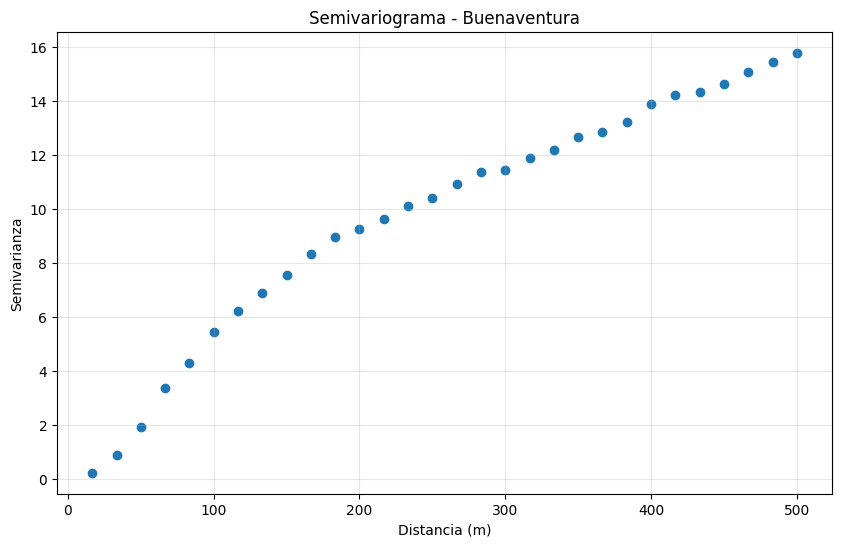

In [13]:
data = variograma.data(n=100, force=False)
x1 = variograma.bins
y1 = variograma.experimental
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x1, y1, label='Semivariograma')
ax.set_title(f"Semivariograma - Buenaventura")
ax.set_xlabel("Distancia (m)")
ax.set_ylabel("Semivarianza")
ax.grid(True, alpha=0.3)
plt.savefig("Semivariograma_Buenaventura.png", dpi=300)

parametros = variograma.parameters


print(f" - Rango: {parametros[0]:.2f} m")
print(f" - Sill: {parametros[1]:.2f}")
print(f" - Nugget: {parametros[3]:.2f}")

🔍 Buscando archivos LiDAR en: Tumaco


100%|██████████| 40/40 [00:00<00:00, 122.16it/s]



✅ Procesados 20 archivos


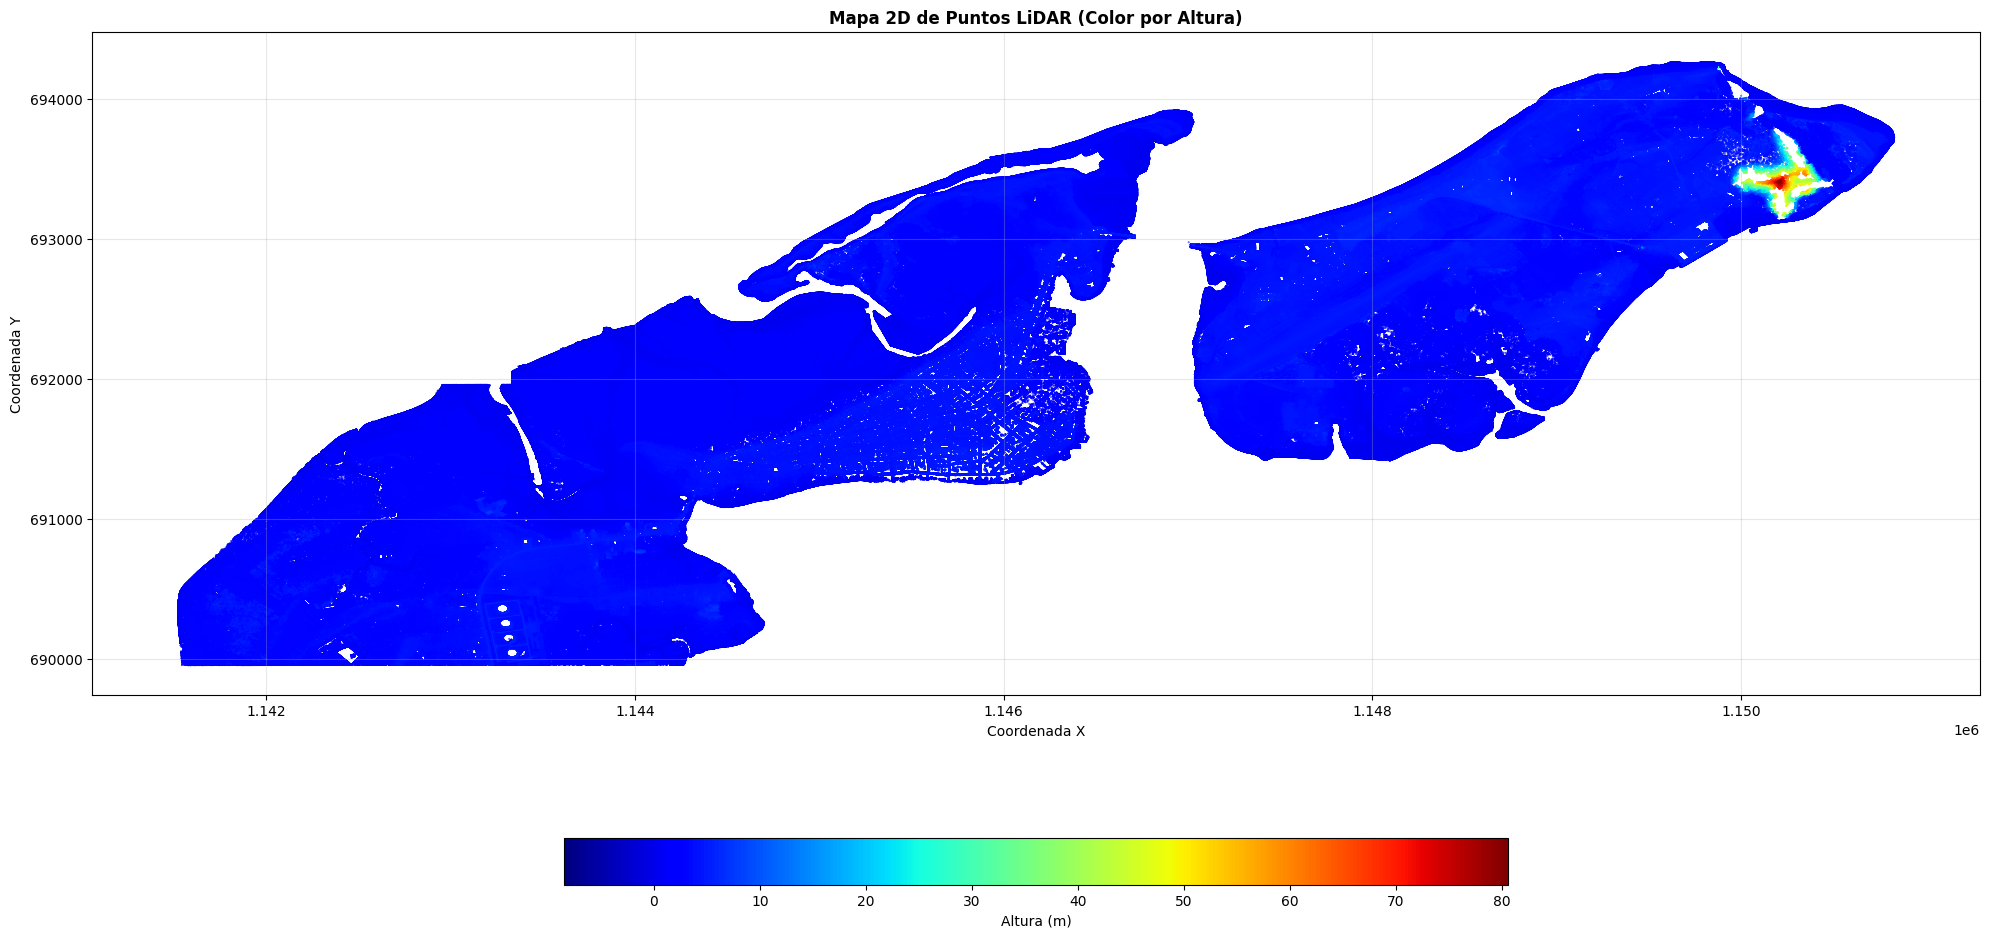

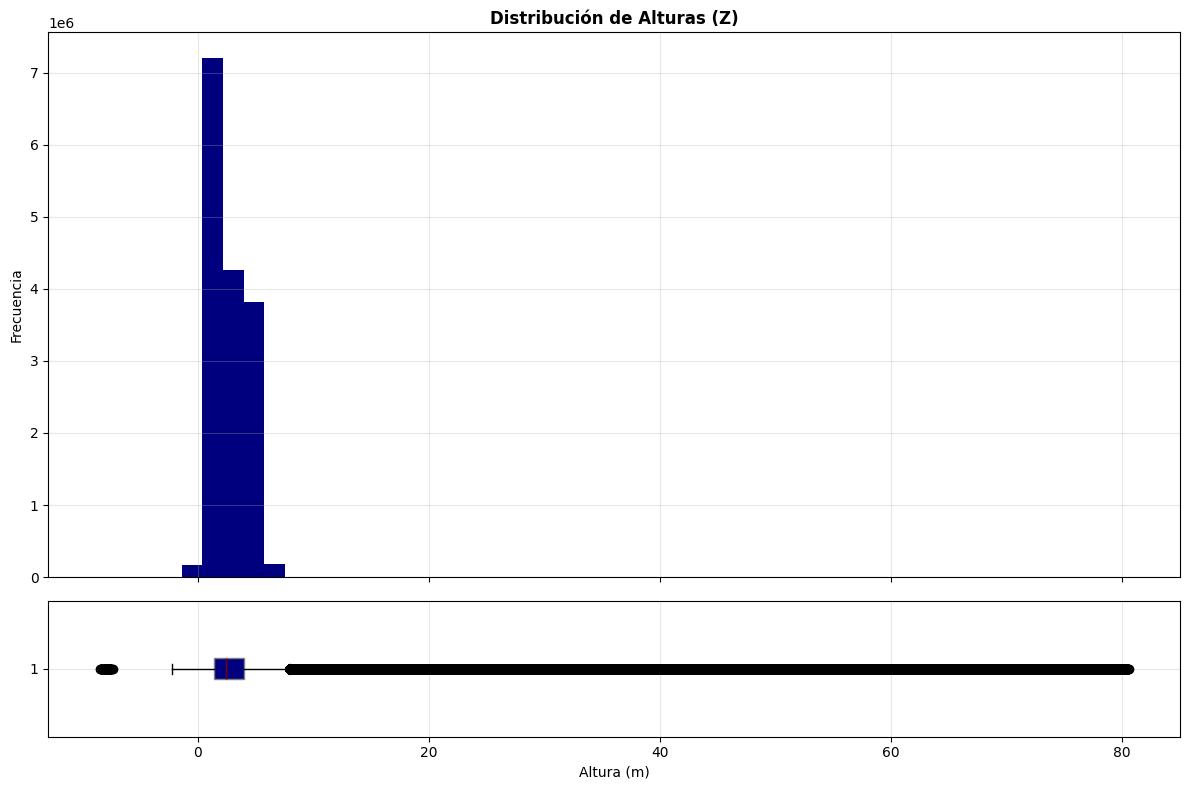


📊 Métricas de altura:
 - Máxima: 80.60 m
 - Mínima: -8.48 m
 - Media: 2.70 m
 - Desviación estándar: 1.99 m


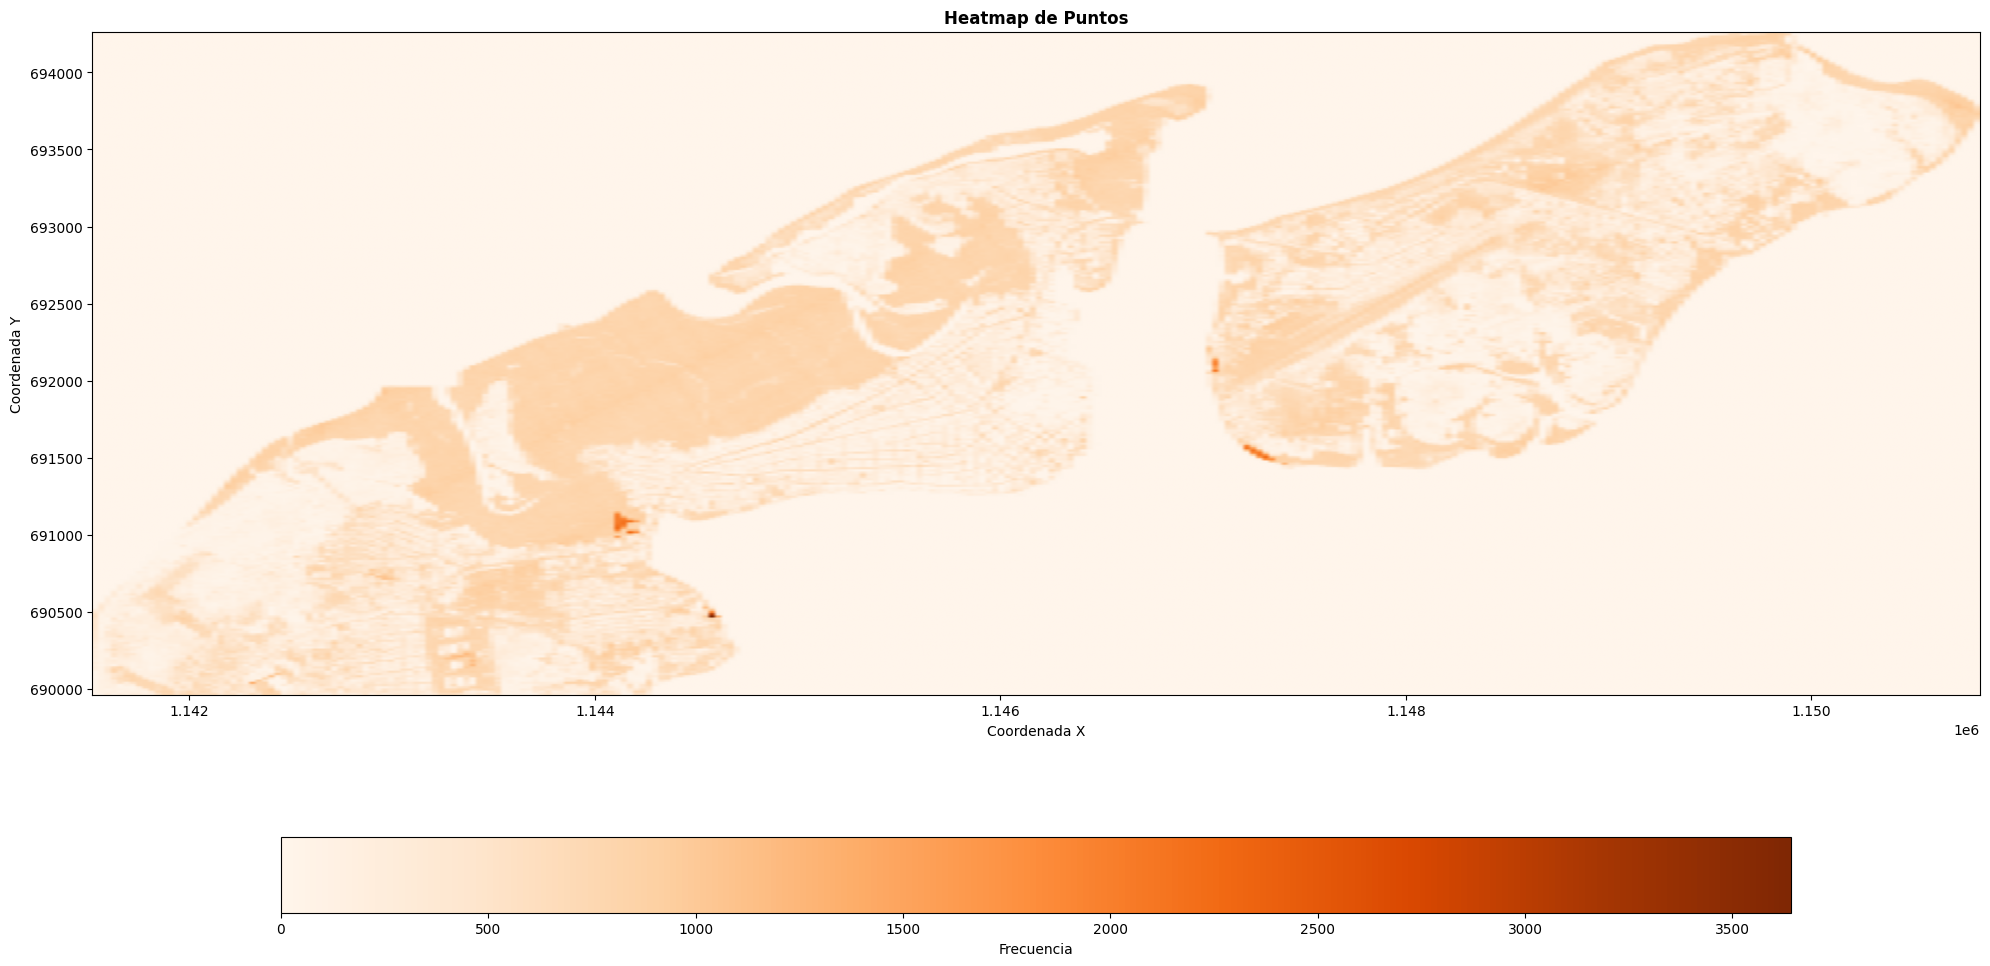

In [2]:

# ========= CONFIGURACIÓN =========
carpeta = "Tumaco"  # <-- Cambiar por tu ruta
magna_oeste = 'EPSG:3114'

LAT_mean = 14.27


# ========= EJECUCIÓN PRINCIPAL =========
if __name__ == "__main__":
    try:
        # 1. Procesar archivos
        x, y, z = procesar_lidar(carpeta, LAT_mean)
        
        # 2. Visualización (solo mapa 2D ahora)
        visualizar_mapa_2d(x, y, z, figurax =20, figuray=10, orientacion ='horizontal')
        
        plt.savefig("Mapa_puntos_Tumaco.png", dpi=300)
        plt.show()
        
        histograma(z)
                     
        plt.savefig("histograma_Tumaco.png", dpi=300)
        plt.show()
        
        # 4. Análisis
        
        analisis_adicional(z)
        
        generar_heatmap(x, y, bins=300, figurax =20, figuray=10, orientacion='horizontal')
        
        plt.savefig("heatmap_Tumaco.png", dpi=300)
        plt.show()
        
               
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")

 - Rango: 342.17 m
 - Sill: 1.89
 - Nugget: 0.00


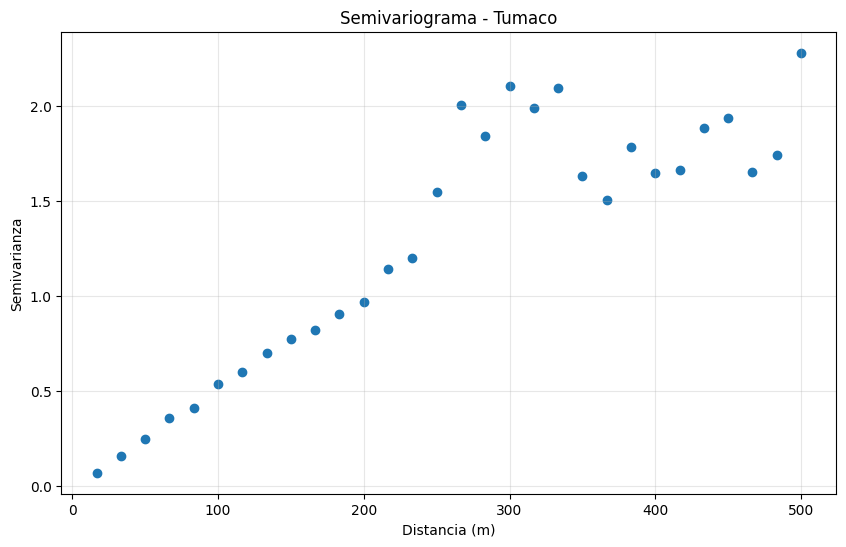

In [16]:
data = variograma.data(n=100, force=False)
x1 = variograma.bins
y1 = variograma.experimental
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x1, y1, label='Semivariograma')
ax.set_title(f"Semivariograma - Tumaco")
ax.set_xlabel("Distancia (m)")
ax.set_ylabel("Semivarianza")
ax.grid(True, alpha=0.3)
plt.savefig("Semivariograma_Tumaco.png", dpi=300)

parametros = variograma.parameters


print(f" - Rango: {parametros[0]:.2f} m")
print(f" - Sill: {parametros[1]:.2f}")
print(f" - Nugget: {parametros[3]:.2f}")

/home/chrisbermudezr/Modelos_Terreno/env/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_144726/2248819122.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes1[i].legend()


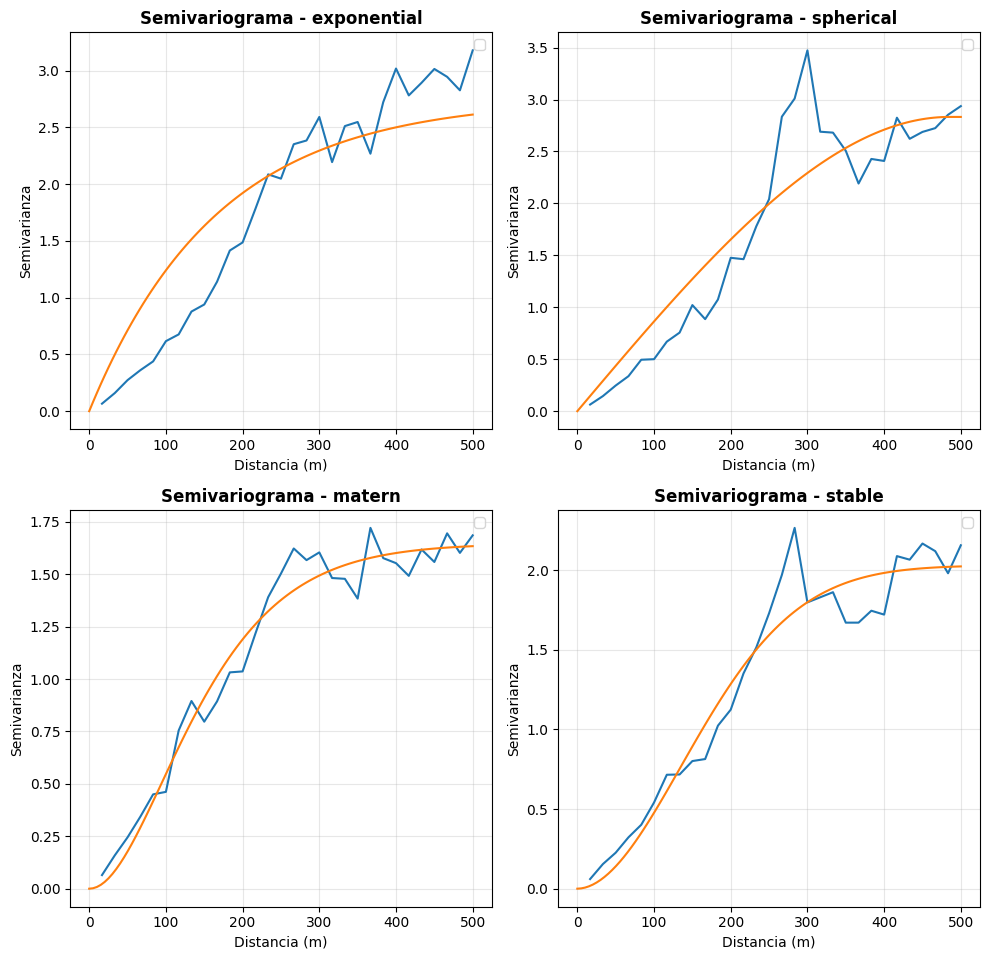

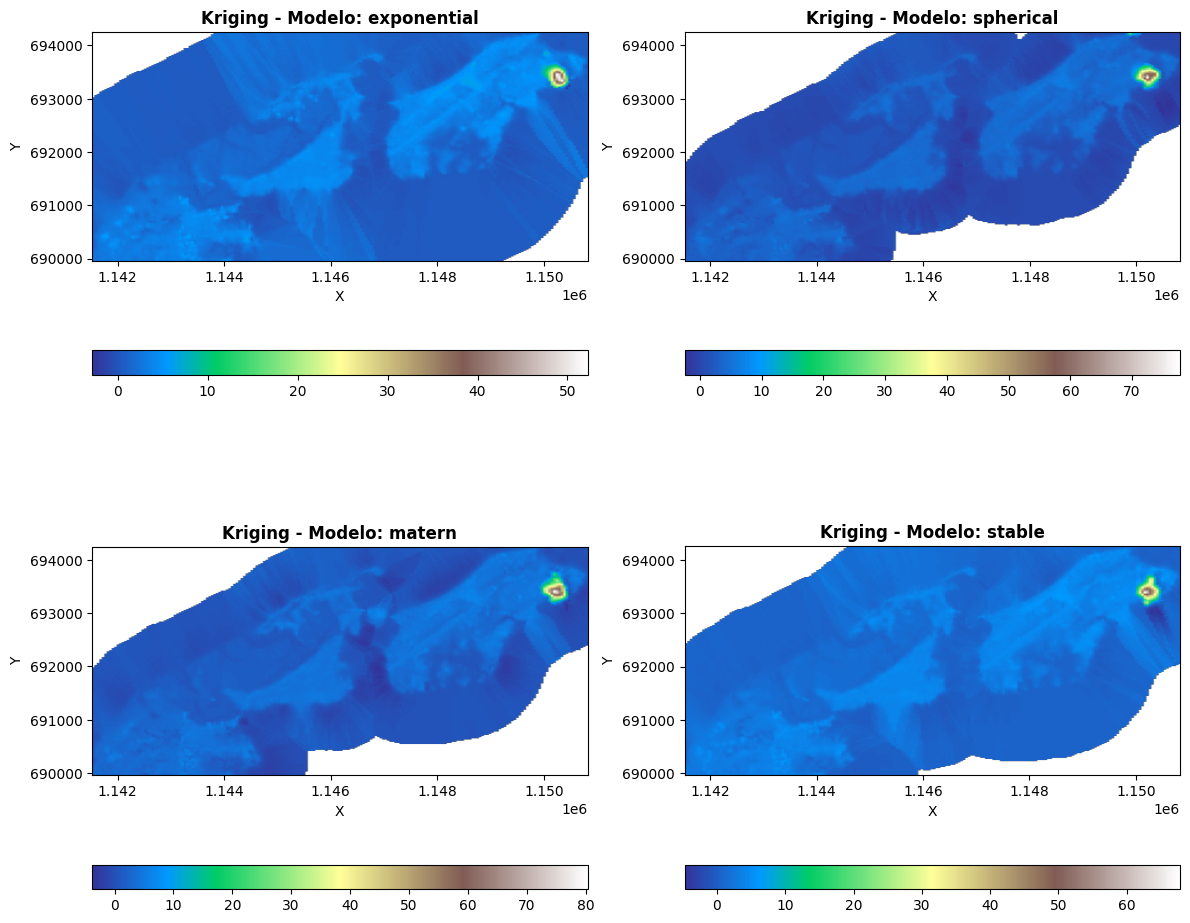

In [4]:
import matplotlib.pyplot as plt

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados_semivariograma = []
resultados_kriging = []

# --- Calcular semivariogramas ---
for modelo in modelos:
    variograma, parametros = calcular_semivariograma(x, y, z, num_bins=30, modelo=modelo)
    resultados_semivariograma.append((modelo, variograma, parametros))

# --- Ejecutar Kriging ---
for modelo in modelos:
    gridx, gridy, z_krig = kriging_interpolacion_skg(x, y, z, grid_res=200, modelo=modelo)
    resultados_kriging.append((modelo, gridx, gridy, z_krig))

# --- Gráfica de semivariogramas ---
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes1 = axes1.ravel()

for i, (modelo, variograma, parametros) in enumerate(resultados_semivariograma):
    fig_temp = variograma.plot()
    ax_temp = fig_temp.axes[0]

    for line in ax_temp.get_lines():
        axes1[i].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())

    axes1[i].set_title(f"Semivariograma - {modelo}", fontweight='bold')
    axes1[i].set_xlabel("Distancia (m)")
    axes1[i].set_ylabel("Semivarianza")
    axes1[i].grid(True, alpha=0.3)
    axes1[i].legend()
    plt.close(fig_temp)  # Cerrar figura temporal para evitar ventanas extras

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout(rect=[0, 0.03, 1, 1])
fig1.savefig("Semivariogramas_Experimentales_Tumaco.png", dpi=300)
plt.show()

# --- Gráfica de mapas Kriging ---
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes2 = axes2.ravel()

for i, (modelo, gridx, gridy, z_krig) in enumerate(resultados_kriging):
    im = axes2[i].imshow(
        z_krig,
        origin='lower',
        extent=[gridx[0], gridx[-1], gridy[0], gridy[-1]],
        cmap='terrain'
    )
    axes2[i].set_title(f'Kriging - Modelo: {modelo}', fontweight='bold')
    axes2[i].set_xlabel("X")
    axes2[i].set_ylabel("Y")
    fig2.colorbar(im, ax=axes2[i], orientation='horizontal', fraction=0.046)

# Quitar subplots vacíos si sobran
for j in range(len(modelos), len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout(rect=[0, 0.03, 1, 1])
fig2.savefig("kriging_Tumaco.png", dpi=300)
plt.show()







--- Resultados para el modelo: exponential ---
RMSE: 0.65 | MSE: 0.42 | R²: 0.85

--- Resultados para el modelo: spherical ---
RMSE: 0.74 | MSE: 0.54 | R²: 0.81

--- Resultados para el modelo: matern ---
RMSE: 0.72 | MSE: 0.52 | R²: 0.81

--- Resultados para el modelo: stable ---
RMSE: 0.73 | MSE: 0.53 | R²: 0.87


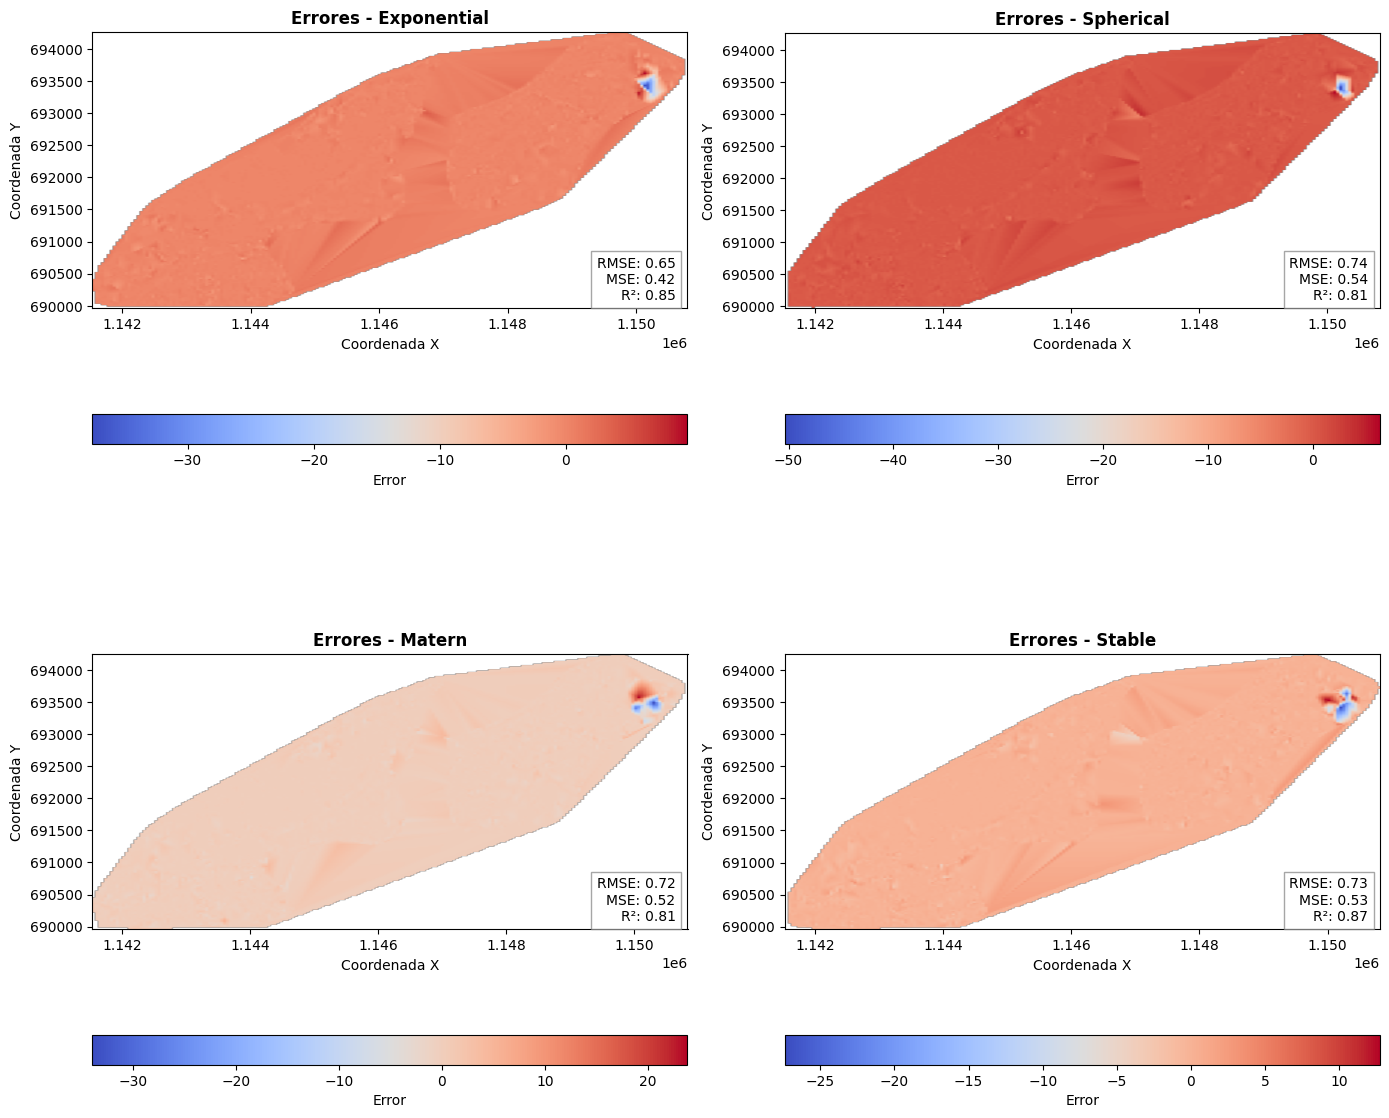

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

modelos = ['exponential', 'spherical', 'matern', 'stable']
resultados = []

# Ejecutar Kriging y validación cruzada para cada modelo
for modelo in modelos:
    print(f"\n--- Resultados para el modelo: {modelo} ---")
    gridx, gridy, z_kriging, error_map, rmse, mse, r2, final_variograma = kriging_errores_validacion_cruzada(
        x, y, z, grid_res=200, modelo=modelo, num_folds=5
    )
    rmse = np.sqrt(mse)
    
    print(f"RMSE: {rmse:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")
    
    resultados.append({
        'modelo': modelo,
        'gridx': gridx,
        'gridy': gridy,
        'error_map': error_map,
        'rmse': rmse,
        'mse': mse,
        'r2': r2
    })

# Crear figura 2x2 con los mapas de errores
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.ravel()

for i, res in enumerate(resultados):
    im = axs[i].imshow(
        res['error_map'],
        extent=(res['gridx'].min(), res['gridx'].max(), res['gridy'].min(), res['gridy'].max()),
        origin='lower',
        cmap='coolwarm'
    )
    axs[i].set_title(f"Errores - {res['modelo'].capitalize()}", fontweight='bold')
    axs[i].set_xlabel("X")
    axs[i].set_ylabel(" Y")
    fig.colorbar(im, ax=axs[i], label="Error", orientation='horizontal', fraction=0.046)

    # Agregar texto con métricas en la esquina inferior derecha del subplot
    texto_metricas = f"RMSE: {res['rmse']:.2f}\nMSE: {res['mse']:.2f}\nR²: {res['r2']:.2f}"
    axs[i].text(0.98, 0.02, texto_metricas, transform=axs[i].transAxes,
                fontsize=10, color='black', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))

plt.tight_layout()
plt.savefig("errores_kriging_modelos_Tumaco.png", dpi=300)
plt.show()
